# Notebook to test the Simulation module

Here is the actual use case of the Simulation module. What it does:
  - initializes it
  - gives it the required inputs
  - runs it
  - analyzes the results

## Imports

In [1]:
from simulation import Simulation
import pandas as pd
import numpy as np
from class_definitions import Program
import itertools
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from astroplan import Observer
from scheduler import generateQ

### Create the programs

In [35]:
# Define the programs
color_pallette = itertools.cycle([mcolors.rgb2hex(color) for color in plt.get_cmap("Set2").colors])

real_time_share = {
    "600": 0.034,
    "703": 0.144,
    "708": 0.062,
    "714": 0.045,
    "500": 0.255,  # real one: 0.205,
    "410": 0.161,
}

# Correct the time share so that it sums to 1
corrected_time_share = dict(
    zip(
        real_time_share.keys(),
        np.array(list(real_time_share.values())) * 1 / sum(real_time_share.values()),
    )
)

# Eventually this would be imported from the gitlab with the files.
prog600 = Program(600, "COR", corrected_time_share["600"], 1, plot_color=next(color_pallette))
prog703 = Program(703, "COR", corrected_time_share["703"], 2, plot_color=next(color_pallette))
prog708 = Program(708, "COR", corrected_time_share["708"], 2, plot_color=next(color_pallette))
prog714 = Program(714, "COR", corrected_time_share["714"], 2, plot_color=next(color_pallette))
prog500 = Program(500, "COR", corrected_time_share["500"], 1, plot_color=next(color_pallette))
prog410 = Program(410, "CAM", corrected_time_share["410"], 0, plot_color=next(color_pallette))

# Check time allocation is correct and sums to 1
programs = [prog600, prog703, prog708, prog714, prog500, prog410]
time_alloc = [prog.time_share_allocated for prog in programs]
print("Total time allocation: ", sum(time_alloc))

Total time allocation:  0.9999999999999999


In [36]:
for prog in programs:
    print(prog)

Program(
    ID = 600
    Instrument = COR
    Time allocated = 0.0485021398002853
    Priority = 1.2)
Program(
    ID = 703
    Instrument = COR
    Time allocated = 0.20542082738944362
    Priority = 1.0)
Program(
    ID = 708
    Instrument = COR
    Time allocated = 0.08844507845934378
    Priority = 1.0)
Program(
    ID = 714
    Instrument = COR
    Time allocated = 0.06419400855920113
    Priority = 1.0)
Program(
    ID = 500
    Instrument = COR
    Time allocated = 0.3637660485021398
    Priority = 1.2)
Program(
    ID = 410
    Instrument = CAM
    Time allocated = 0.22967189728958629
    Priority = 1.4)


## Initialize the simulation

In [37]:
start_date = date(2023, 10, 2)
end_date = start_date + timedelta(days=13)
print(f"{start_date= }")
print(f"{end_date = }")

start_date= datetime.date(2023, 10, 2)
end_date = datetime.date(2023, 10, 15)


In [38]:
lasilla = Observer.at_site("lasilla")
sim = Simulation(
    start_date,
    end_date,
    observer=lasilla,
    night_within="nautical",
    scheduler_algorithm=generateQ,
    keep_top_n=50,
)

# Add the programs
for prog in programs:
    sim.add_program(
        prog,
        f"programs/instructions/SchedulingInstructions_{prog.progID}{prog.instrument}.csv",
    )

Adding program: 600COR
Adding program: 703COR


Adding program: 708COR
Adding program: 714COR
Adding program: 500COR
Adding program: 410CAM


In [39]:
# Run the simulation
plans, observation_history, night_history = sim.run()


Running night: 2023-10-02
Determining observability of targets...
Building observations...


  0%|          | 0/223 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-03
Determining observability of targets...
Building observations...


  0%|          | 0/206 [00:00<?, ?it/s]

Building plan...


/home/nunger/Dropbox/Postdoc/EULER Scheduling/SCOPES/SCOPES/merits.py:37: RuntimeWarning: overflow encountered in exp
  m = 0.5 + (1 / (1 + np.exp(((pct_diff / beta) ** alpha))))


Updating tracking tables and saving plan...

Running night: 2023-10-04
Determining observability of targets...
Building observations...


  0%|          | 0/206 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-05
Determining observability of targets...
Building observations...


  0%|          | 0/207 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-06
Determining observability of targets...
Building observations...


  0%|          | 0/206 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-07
Determining observability of targets...
Building observations...


  0%|          | 0/196 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-08
Determining observability of targets...
Building observations...


  0%|          | 0/188 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-09
Determining observability of targets...
Building observations...


  0%|          | 0/186 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-10
Determining observability of targets...
Building observations...


  0%|          | 0/195 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-11
Determining observability of targets...
Building observations...


  0%|          | 0/184 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-12
Determining observability of targets...
Building observations...


  0%|          | 0/171 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-13
Determining observability of targets...
Building observations...


  0%|          | 0/169 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-14
Determining observability of targets...
Building observations...


  0%|          | 0/170 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...

Running night: 2023-10-15
Determining observability of targets...
Building observations...


  0%|          | 0/161 [00:00<?, ?it/s]

Building plan...
Updating tracking tables and saving plan...


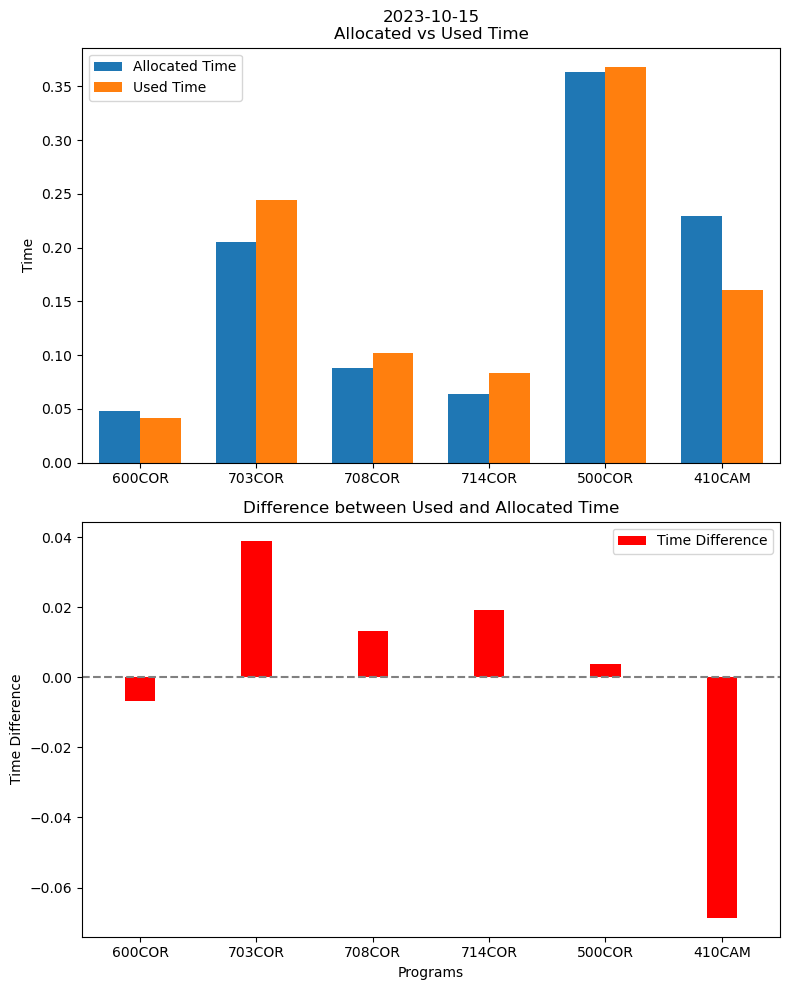

In [40]:
sim.plot_time_share(display=True)

In [41]:
obs = sim.plans[1].observations[4]
prog = obs.target.program
print(f"{prog.progID = }\n")

print(f"allocated = {prog.time_share_allocated}")
print(f"current = {prog.time_share_current}")
print(f"pct_diff = {prog.time_share_pct_diff}")

prog.progID = 703

allocated = 0.20542082738944362
current = 0.24445893089960882
pct_diff = 0.039038103510165206


In [42]:
print("Priorities:")
print(obs.target.program.priority)
print(obs.target.priority)

Priorities:
1.0
0.05


In [43]:
time_share_merit = np.prod([merit.evaluate(obs) for merit in obs.target.fairness_merits])
print(f"{time_share_merit = }")

time_share_merit = 0.9279718945662709


In [44]:
obs.fairness()

0.9743704892945845

In [45]:
obs.target.efficiency_merits

[Merit(CulMapping, efficiency, {})]

In [46]:
obs.evaluate_score(True)

Fairness: 0.9743704892945845
Sensibility: 1.0
Efficiency: 0.9999462038623945
Rank score: 0.9743180719256637


0.9743180719256637

## Random tests for development

In [20]:
# night = Night(date(2023, 9, 20), "nautical", lasilla)

In [26]:
cat = pd.read_csv(sim.programs[prog600]["file"])

observation_history = pd.DataFrame(columns=["target", "program", "obs_time", "obs_date", "score"])

# Generate some dummy data
observation_history = (
    observation_history.assign(target=np.concatenate([cat["catalog_name"], cat["catalog_name"]]))
    .assign(program=prog703.progID)
    .assign(obs_time=(np.random.random(len(cat) * 2) * 100) + 50000)
    .sort_values(by="obs_time")
    .drop(index=np.random.randint(0, len(cat) * 2, 10))
    .reset_index(drop=True)
)

# print the observation_history table
observation_history

,target,program,obs_time,obs_date,score
0,HD20794,703,50000.494720,NaN,NaN
1,HD158198,703,50012.663038,NaN,NaN
2,HD144585,703,50016.682201,NaN,NaN
3,HD190248,703,50031.230765,NaN,NaN
4,HD20794,703,50031.346652,NaN,NaN
5,HD190248,703,50034.372995,NaN,NaN
6,HD192310,703,50054.538136,NaN,NaN
7,HD108309,703,50068.926258,NaN,NaN
8,HD161612,703,50076.414902,NaN,NaN
9,HD108309,703,50082.576663,NaN,NaN


In [27]:
cat["catalog_name"]

0      HD1581
1     HD10700
2     HD20794
3    HD65907A
4    HD108309
5    HD144585
6    HD158198
7    HD161612
8    HD190248
9    HD192310
Name: catalog_name, dtype: object

In [28]:
last_observation_dates = cat["catalog_name"].apply(
    lambda x: observation_history.loc[observation_history["target"] == x]["obs_time"].max()
    if x in observation_history["target"].unique()
    else 0
)

last_observation_dates

0        0.000000
1    50095.655811
2    50031.346652
3        0.000000
4    50082.576663
5    50016.682201
6    50012.663038
7    50076.414902
8    50034.372995
9    50092.986043
Name: catalog_name, dtype: float64

In [29]:
cat_mod = (
    cat.assign(last_obs=last_observation_dates)
    .assign(pct_overdue=lambda df: (50120 - (df["last_obs"] + df["cadence"])) / df["cadence"])
    .assign(score=lambda df: df["priority"] / df["pct_overdue"])
    # .assign(keep=lambda df: (df["pct_overdue"] > 0) & (df["score"] <= df["score"].quantile(0.75)))
)
cat_mod.sample(10)

,catalog_name,simbad_id,ra,dec,texp,priority,cadence,comments_for_observer,last_obs,pct_overdue,score
1,HD10700,* tau Cet,01:44:04.0831,-15:56:14.927,1200,0,7,NaN,50095.655811,2.477741,0.0
8,HD190248,* del Pav,20:08:43.6088,-66:10:55.442,1200,0,7,NaN,50034.372995,11.232429,0.0
6,HD158198,HD 158198,17:29:25.5978,-33:45:38.071,1200,0,7,NaN,50012.663038,14.333852,0.0
7,HD161612,HD 161612,17:47:57.5496,-34:01:07.948,1200,0,7,NaN,50076.414902,5.226443,0.0
0,HD1581,* zet Tuc,00:20:04.2586,-64:52:29.257,1200,0,7,NaN,0.000000,7159.000000,0.0
5,HD144585,HD 144585,16:07:03.3696,-14:04:16.671,1200,0,7,NaN,50016.682201,13.759686,0.0
4,HD108309,HD 108309,12:26:48.1417,-48:54:47.499,1200,0,7,NaN,50082.576663,4.346191,0.0
2,HD20794,* e Eri,03:19:55.6509,-43:04:11.215,1200,0,7,NaN,50031.346652,11.664764,0.0
9,HD192310,HD 192310,20:15:17.3913,-27:01:58.711,1200,0,7,NaN,50092.986043,2.859137,0.0
3,HD65907A,HD 65907,07:57:46.9142,-60:18:11.058,1200,0,7,NaN,0.000000,7159.000000,0.0


In [ ]:
# Filter cat_mod for observable targets
observable_cat_mod = cat_mod[keep]

# Filter for pct_overdue > 0 and sort by score in ascending order
filtered_sorted = observable_cat_mod[observable_cat_mod["pct_overdue"] > 0].sort_values(
    by="score", ascending=True
)

# Take the top 50 targets
top_50 = filtered_sorted.head(50)

# Create a boolean series for marking top 50 targets
top_50_marks = cat_mod["catalog_name"].isin(top_50.index)

In [30]:
# Filter for pct_overdue > 0 and sort by score in ascending order
filtered_sorted = cat_mod[cat_mod["pct_overdue"] > 0].sort_values(by="score", ascending=True)

# Take the top 50 targets
top_50 = filtered_sorted.head(50)

# Create a boolean series for marking top 50 targets
top_50_marks = cat_mod.index.isin(top_50.index)

In [31]:
np.where(top_50_marks)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)

In [14]:
cat_mod["keep"].values

array([ True,  True, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True, False,  True, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False,  True, False, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False,  True, False, False,  True,  True,  True, False,  True,
        True,  True,  True, False, False, False,  True])